In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
import sys
#sys.path.append('C:/Users/Fabian/gempy')
sys.path.insert(1,'/home/fabian/gempy')
import gempy as gp

In [72]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

#import vtk
#import evtk

from scipy.interpolate import griddata

In [73]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa
import gempy.utils.decision_making as dm

In [74]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = ".././input_data/Fab_ResModel_Foliations2.csv",
                        path_i = ".././input_data/Fab_ResModel_Points4_small_offset.csv")
                         #path_i = ".././input_data/Fab_ResModel_finite_fault.csv")
geo_data.n_faults = 1

In [75]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

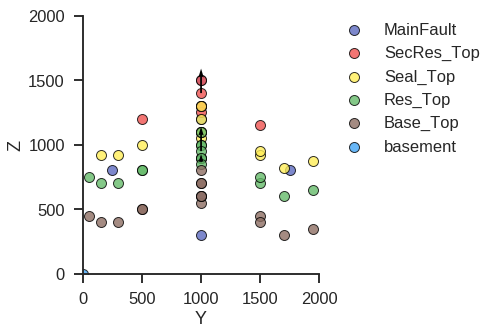

In [76]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data, direction='x')

In [77]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [78]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [79]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients',
                                 compile_theano=True, dtype ='float64', theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1


In [80]:
#interp_data.interpolator.tg.inf_factor.set_value(np.zeros(7, dtype='int32'))
#interp_data.interpolator.tg.inf_factor.get_value()

In [81]:
type(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values)

numpy.ndarray

In [82]:
import pandas as pd

In [83]:

# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [84]:
gp.get_kriging_parameters(interp_data)

range 0.888231183368655 3464.101615137755
Number of drift equations [3 3]
Covariance at 0 0.018784634169249557
orientations nugget effect 0.01
scalar nugget effect 1e-06


In [85]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

#lith_block = np.round(lith_sol[0]).reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])
#
##fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
##                                     geo_data.resolution[1],geo_data.resolution[2])
#fault_block_0 = np.round(fault_sol[0])#.astype(int)
#fault_block = fault_block_0.reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])

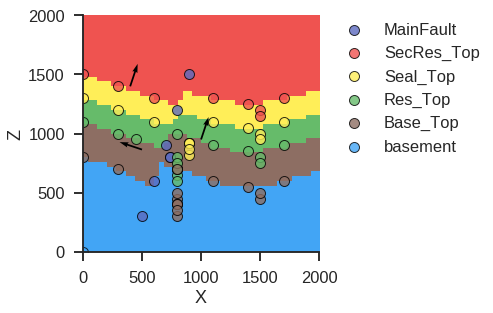

In [86]:
gp.plotting.plot_section(geo_data, lith_sol[0], 25, plot_data=True)

In [87]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [88]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n-1)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n-1)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n-1)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n-1)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n-1)

In [89]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [90]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 5

permeable_l = [secres_n, over_n]

In [91]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

In [92]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
#gp.plotting.plot_section(geo_data, lith_block, int(resolution/2), plot_data=1, direction='y')
#plt.savefig('computed_block.pdf', transparent=True)

In [93]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

In [94]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith, fault, bottom_z, formation_bool, fault_bool):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5).astype(int) #rounding up to avoid voxel connection to outside borders
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(geo_data, lith, fault, seal_th, trap_n):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
        gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 0)
    trap_keys = [int(k) for k in lith_to_labels_lot["%s" % trap_n].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["0"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    #gp.topology.classify_edges(G, centroids, lith.reshape(resolution,resolution,resolution), fault.reshape(resolution,resolution,resolution))   
    gp.topology.classify_edges(G, centroids, lith_pad, fault_pad)   
    # If too many traps, model probably broken:
    print("NUMBER OF POTENTIAL TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        print('Too many traps detected. Reservoir discontinuous or model probably broken.')
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                traps.append(tk)
                print('TRAP CONFIRMED:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [95]:
# get juxtaposition with itself
def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n):
    hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
    maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
    if np.any(maxline_hw):
        max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z
        return max_jux
    else:
        return 0

#def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
#                        res_n):
#    juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
#                        lith_target=res_n, lith_jux=res_n, target_side='fw', projection='automatic')
#    if np.any(juxta):
#        max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
#        return max_jux
#    else:
#        return 0

In [96]:
#hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
#maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
#if np.any(maxline_hw):
#    max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z

In [97]:
# get juxtapositions with any other input perm layers
def perm_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, lith_perm):
    if isinstance(lith_perm, int):
        lith_perm = [lith_perm]
    juxta_list = np.zeros((len(lith_perm),2))
    juxta_list[:,0] = np.array(lith_perm)
    for i in lith_perm:
        juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, i, target_side='fw', projection='automatic')
        if np.any(juxta):
            max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
            juxta_list[(np.argwhere(juxta_list[:,0]==i)),1] = max_jux
    juxta_list = np.delete(juxta_list, np.argwhere(juxta_list[:,1]==0), 0)
    return juxta_list        

In [98]:
# get SSF on base of fault analysis module
def fa_SSF(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position='faultmax_argrelmax', order=40):
    fault_throws = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position=position, order=order, artifact_filter='on')
    max_throw = np.nanmax(fault_throws)
    contact = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw')
    proj = fa.project_voxels(contact, form='2D')
    lith_thickness = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw',
                      position=position, order=order, artifact_filter='on')
    min_thickness = np.nanmin(lith_thickness)
    SSF = max_throw/min_thickness
    print('SSF = %s / %s = %s' % (max_throw, min_thickness, SSF))
    return SSF

In [99]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps
def max_trap_vol(geo_data, interp_data, lith_sol, fault_sol, res_n, seal_n, fault_n, GX, GY, seal_surf_v):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    trap_n = (np.max(formation_numbers)+1)
    
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]
    
    seal_thickness_all = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, 
                                                 seal_n, fault_n, fault_side='fw',
                      position='faultmax_argrelmax', order=40)
    seal_thickness = np.nanmin(seal_thickness_all)
    
    seal_thresh = vox_size_z
    if seal_thickness < seal_thresh:
        print("Seal layer compromised, too thin.")
        print('CONTROL: STRAT. SEAL BREACH')
        # Trap failed due to assumed seal cap discontinuity: return no volume, no trap, SSF = nan
        return 0, np.zeros_like(lith_block), np.nan, 4    

    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    highest_spill_point = sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY)
    
    if highest_spill_point == []:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith_block)
        return trap_vol, final_trap_mask, np.nan, 0
    
    spill_z = np.max(highest_spill_point[2])
    leak_self_z = self_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n)
    # need to implement variability of permeable layers
    juxta_above = perm_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n, lith_perm=permeable_l)
    
    print('SPILL POINT COORDINATES:', highest_spill_point)
    print('LEAK SELF Z-POSITION:', leak_self_z)
    print('JUXTA with permable layers:', juxta_above)

    SSF = fa_SSF(geo_data, lith_sol, fault_sol, seal_n, fault_n,
                      position='faultmax_argrelmax', order=40)
    if SSF > SSF_c:
        print('SSF threshold exceeded, shale smear assumed to be incomplete.')
        SSF_sealing = False
    else: 
        print('SSF in confidence range, complete shale smear sealing assumed.')
        SSF_sealing = True
        
    #general_sealing = False # might be implemented later (as binomial probability)
    
    if juxta_above.size == 0:
        leak_z = leak_self_z
        # no SSF necessary (but still have to be calculated if relevant in probabilistic model)
        # possible use of general fault sealing probability
        max_z = np.nanmax([spill_z, leak_z])  
        if max_z == spill_z:
            trap_control = 1
            print('CONTROL: SPILL Z')
        else:
            trap_control = 2
            print('CONTROL: LEAK Z')
    else:
        # check for SSF/general sealing
        if SSF_sealing == False: 
            leak_above_z = np.max(juxta_above[:,1])
            max_z = np.nanmax([spill_z, leak_above_z]) 
            if max_z == spill_z:
                trap_control = 1
                print('CONTROL: SPILL Z')
            else:
                trap_control = 3
                print('CONTROL: PERM. JUXTA Z')
        #elif general_sealing == False:
        #    max_z = np.nanmax([spill_z, leak_self_z])
        #    if max_z == spill_z:
        #        trap_control = 1
        #    else:
        #        trap_control = 2   
        else:
            max_z = spill_z
            trap_control = 1
            print('CONTROL: SPILL Z')
            
    ### MAKE AN OWN FUNCTION TO GET MAX_Z!              
        
    rounded_lith = np.around(lith_block).astype(int)
    rounded_fault = np.around(fault_block).astype(int)
    res_n_bool = rounded_lith == res_n
    fault_bool = rounded_lith == 2
        
    pre_trap_mask = res_mask(lith_block, fault_block, max_z, res_n_bool, fault_bool)
          
    # volume cells for counting
    vol_cells = 0
    lith_copy = np.copy(lith_block)
        
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        #trap_control = 0
        return 0, pre_trap_mask, SSF, trap_control
    else:
        lith_copy[pre_trap_mask_bool] = trap_n                           # setting reservoir above bottom on footwall side 
        final_trap_mask = topo_analysis(geo_data, lith_copy, fault_block, seal_thickness, trap_n)
        lith_copy[final_trap_mask] = (trap_n + 1)                        # setting final trap to formation value = trap_n + 1
        vol_cells = np.count_nonzero(final_trap_mask)
            
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        # revert to lith_block without any masks
        #lith[pre_trap_mask_bool] = res_n      
        #return the maximum reservoir volume
        return trap_vol, final_trap_mask, SSF, trap_control

In [100]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

### Setting up the probabilistic model

In [101]:
lith_unc_stds = np.array([40,60,80,100])
# NEXT: create a Z modifier through which we can loop

In [102]:
lith_ids = geo_data.interfaces["formation"].dropna().unique()[1:-1]
print(lith_ids)

[SecRes_Top, Seal_Top, Res_Top, Base_Top]
Categories (6, object): [MainFault, SecRes_Top, Seal_Top, Res_Top, Base_Top, basement]


In [103]:
lith_numbers = geo_data.formations.formation_number[1:]

In [104]:
lith_Z_modifier = []

for liID, stdi in zip(lith_ids, lith_unc_stds):
    stoch = pymc.Normal(liID+'_stoch', 0, 1./np.square(stdi/rescale_f))
    lith_Z_modifier.append(stoch)

In [105]:
faultside_ids = geo_data.interfaces["fault side"].dropna().unique()
print(faultside_ids)

['nan' 'hanging wall' 'footwall']


In [106]:
std_offset = 150
fault_Z_modifier = pymc.SkewNormal(faultside_ids[1]+'offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

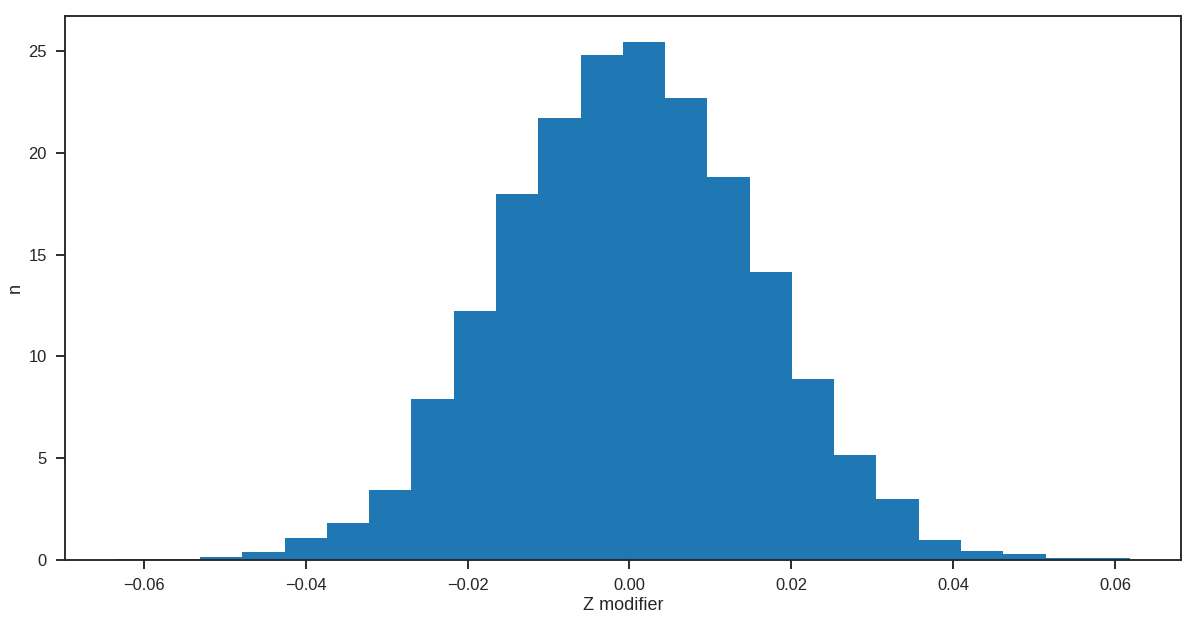

In [107]:
# sample from a distribution
samples = [lith_Z_modifier[1].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

In [108]:
import copy
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)
#interp_data_stoch_init = copy.deepcopy(interp_data)

In [109]:
# NEW INTERP FUNCTION
@pymc.deterministic(trace=True)
def input_data(value=0, geo_data_stoch_init=geo_data_stoch_init, lith_Z_modifier=lith_Z_modifier, 
              fault_Z_modifier=fault_Z_modifier, verbose= 0):
    
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    for e, foID in enumerate(lith_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == foID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(lith_Z_modifier[e])
        
    sel_fa = gp.get_data(interp_data.geo_data_res, verbosity=2)['fault side'] == 'hanging wall'
    geo_data_stoch.loc[sel_fa, 'Z']  += np.array(fault_Z_modifier)
    
    if verbose > 0:
        print(geo_data_stoch)
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [110]:
@pymc.deterministic(trace=False)
def gempy_model(value=0, input_data=input_data, seal_n=seal_n, print_figures=False):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    try:
        # try to compute model
        ls, fs = gp.compute_model(interp_data)
        if print_figures:
            gp.plot_section(geo_data, ls[0], np.int(resolution/2), plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return ls, fs, interp_data
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_sol), np.zeros_like(fault_sol), interp_data

In [111]:
@pymc.deterministic(trace=True)
def trap_analysis(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1], 
                  interp_data=gempy_model[2], print_figures=False, verbose = False):
    
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    try:
        max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return max_vol, SSF, trap_control
    
    except (IndexError, ValueError):
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose == True:
            print("Exception occured.")
        return np.nan, np.nan, 0
#@pymc.deterministic(trace=True)
#def trap_analysis(value=0, input_data=input_data, print_figures=False):
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
#                                           'dip', 'azimuth', 'polarity']] = input_data[1]
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)    
#    try:
#        # try to compute model
#        lith_sol, fault_sol = gp.compute_model(interp_data)
#        if print_figures:
#            gp.plot_section(interp_data.geo_data_res, lith_sol[0], np.int(resolution/2), plot_data=True)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.nan, np.nan, np.nan
#    
#    seal_surf_V = gp.get_surfaces(\
#        interp_data = interp_data, potential_lith=lith_sol[1], \
#        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
#    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
#    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
#                                                    lith_sol, fault_sol, res_n, 
#                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
#    print("Maximum trap volume: %s m³" % max_vol)
#    if print_figures:
#        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
#    return max_vol, SSF, trap_control

No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        798.671875]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 28032000.0 m³


In [112]:
def trap_analysis_post(lith_sol, fault_sol, print_figures=False):
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]  
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
    print("Maximum trap volume: %s m³" % max_vol)
    print('TRAP VOXELS:', np.count_nonzero(trap))
    if print_figures:
        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return max_vol, SSF, trap_control # trap --> what to do about trap return?

In [113]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

In [114]:
# Reservoir thickness
@pymc.deterministic(trace=True)
def thicknesses(value=0, input_data=input_data):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    res_th = np.abs(fw_sb_z-fw_rb_z)
    seal_th = np.abs(fw_r2b_z-fw_sb_z)
    secres_th = np.abs(fw_ob_z-fw_r2b_z) 
    return res_th, seal_th, secres_th

#Seal thickness
#@pymc.deterministic(trace=True)
#def seal_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_r2b_z-fw_sb_z)
#
## Secondary reservoir thickness
#@pymc.deterministic(trace=True)
#def sec_res_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_ob_z-fw_r2b_z) 

In [115]:
block = np.round(lith_sol[0]).astype(int)
block_fb = np.round(fault_sol[0]).astype(int)

lith_id = np.unique(np.round(block).astype(int))
fault_id = np.unique(np.round(block).astype(int))

count = np.zeros((len(lith_id), block.shape[0]))
count_fb = np.zeros((len(fault_id), block_fb.shape[0]))  

@pymc.deterministic(trace=True)
def lith_prob(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1]):
    block = np.round(lith_sol[0]).astype(int)
    block_fb = np.round(fault_sol[0]).astype(int)
    for i, l_id in enumerate(lith_id):
        count[i][block == l_id] += 1 #sum up frequency
    for i, f_id in enumerate(fault_id):
        count_fb[i][block_fb == f_id] += 1 #sum up frequency

In [116]:
iterations = 1000

In [117]:
params = [input_data, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [118]:
dbname="trapmodel_lithSIMPLEMC"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations2"+".hdf5"

In [119]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)
#RUN = pymc.MCMC(model)

In [120]:
RUN.sample(iter=iterations)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          795.88684082]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 27584000.0 m³
 [                  0%                  ] 2 of 1000 complete in 2.1 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 3 of 1000 complete in 3.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          841.65962219]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 20096000.0 m³
 [                  2%                  ] 20 of 1000 complete in 36.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          788.07579041]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 23488000.0 m³
 [                  2%                  ] 21 of 1000 complete in 38.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          809.27757263]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 80.0 / 80.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Chec

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 21
Maximum trap volume: 15616000.0 m³
 [-                 3%                  ] 37 of 1000 complete in 68.7 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in ori

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 27
Maximum trap volume: 22080000.0 m³
 [-                 5%                  ] 51 of 1000 complete in 97.2 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 5%                  ] 52 of 1000 complete in 98.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1355.14450073  920.          800.        ]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 28736000.0 m³
 [--                5%                  ] 53 of 1000 complete in 100.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1341.09085083  920.          960.        ]
LEAK SELF Z-POS

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
Maximum trap volume: 27328000.0 m³
 [--                7%                  ] 70 of 1000 complete in 133.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          728.79455566]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 920.]
 [  2. 840.]]
SSF = 680.0 / 240.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 37
Maximum trap volume: 19520000.0 m³
 [--                7%                  ] 71 of 1000 complete in 135.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         901.6897583]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PER

NUMBER OF POTENTIAL TRAPS 46
Too many traps detected. Reservoir discontinuous or model probably broken.
Maximum trap volume: 0.0 m³
 [---               8%                  ] 88 of 1000 complete in 168.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          796.24092102]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 27264000.0 m³
 [---               8%                  ] 89 of 1000 complete in 170.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.26940918]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checkin

 [---              10%                  ] 105 of 1000 complete in 202.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          860.81436157]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20032000.0 m³
 [----             10%                  ] 106 of 1000 complete in 204.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          806.32667542]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 

 [----             12%                  ] 124 of 1000 complete in 239.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          849.73838806]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 200.0 / 200.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 16896000.0 m³
 [----             12%                  ] 125 of 1000 complete in 241.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1359.52667236  920.          800.        ]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 126 of 1000 complete in 2

NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 25984000.0 m³
 [-----            14%                  ] 142 of 1000 complete in 275.6 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          837.82203674]
LEAK SELF Z-POSITIO

 [------           15%                  ] 159 of 1000 complete in 310.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.99673462]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 600.0 / 160.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 42
Maximum trap volume: 26176000.0 m³
 [------           16%                  ] 160 of 1000 complete in 312.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        846.587677]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 16064000.0 m³
 [------           16%           

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 3136000.0 m³
 [------           17%                  ] 176 of 1000 complete in 345.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          841.09405518]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 14592000.0 m³
 [------           17%                  ] 177 of 1000 complete in 347.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          811.53549194]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear seali

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 23104000.0 m³
 [-------          19%                  ] 193 of 1000 complete in 381.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.07325745]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 21248000.0 m³
 [-------          19%                  ] 194 of 1000 complete in 383.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          820.46363831]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 18
Maximum trap volume: 14592000.0 m³
 [--------         21%                  ] 211 of 1000 complete in 418.1 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         21%                  ] 212 of 1000 complete in 419.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          575.61252594]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 213 of 1000 complete in 421.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          776.95495605]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 20

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 5824000.0 m³
 [--------         22%                  ] 228 of 1000 complete in 451.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          832.87513733]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 19
Maximum trap volume: 21568000.0 m³
 [--------         22%                  ] 229 of 1000 complete in 453.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          916.50306702]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 320.0 / 80.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAP

 [---------        24%                  ] 246 of 1000 complete in 488.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.44747925]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 120.0 / 80.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 4224000.0 m³
 [---------        24%                  ] 247 of 1000 complete in 490.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          771.48582458]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 19264000.0 m³
 [---------  

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 4288000.0 m³
 [---------        26%                  ] 263 of 1000 complete in 523.8 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 264 of 1000 complete in 525.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          789.67811584]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 265 of 1000 complete in 527.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          833.50067139]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 40.0 

NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 576000.0 m³
 [----------       28%                  ] 282 of 1000 complete in 560.8 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          712.67951965]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 18624000.0 m³
 [----------       28%                  ] 283 of 1000 complete in 562.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          787.33345032]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 240.0 = 0.6666666666666666
SSF in co

 [-----------      30%                  ] 301 of 1000 complete in 597.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         812.4495697]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 600.0 / 200.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 28
Maximum trap volume: 18112000.0 m³
 [-----------      30%                  ] 302 of 1000 complete in 599.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.87254333]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 40.0 / 200.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------      30%                  ] 303 of 1000 complete in 602.1 secNo maxima found for su

NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 20
Maximum trap volume: 12032000.0 m³
 [------------     32%                  ] 320 of 1000 complete in 635.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.86915588]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 21
Maximum trap volume: 15744000.0 m³
 [------------     32%                  ] 321 of 1000 complete in 637.8 secNo maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.         920.         754.8828125]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
S

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 23616000.0 m³
 [------------     33%                  ] 339 of 1000 complete in 673.8 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------------     34%                  ] 340 of 1000 complete in 675.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          796.32766724]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 160.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 27136000.0 m³
 [------------     34%                  ] 341 of 1000 complete in 677.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          767.59613037]
LEAK SELF Z-POSITION: 840.0
JUXTA with permab

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 14
Maximum trap volume: 3008000.0 m³
 [-------------    35%                  ] 357 of 1000 complete in 710.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.33032227]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 22
Maximum trap volume: 19456000.0 m³
 [-------------    35%                  ] 358 of 1000 complete in 712.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          924.55688477]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear a

 [--------------   37%                  ] 373 of 1000 complete in 741.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          874.69940186]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 5312000.0 m³
 [--------------   37%                  ] 374 of 1000 complete in 744.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          904.83612061]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------------   37%                  ] 375 of 1000 complete in 745.7 secNo maxima found for

 [--------------   39%                  ] 391 of 1000 complete in 778.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          771.14891052]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 920.]
 [  2. 960.]]
SSF = 640.0 / 160.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 41
Maximum trap volume: 19328000.0 m³
 [--------------   39%                  ] 392 of 1000 complete in 780.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          728.54103088]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
M

 [---------------  40%                  ] 408 of 1000 complete in 813.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          722.78045654]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 16768000.0 m³
 [---------------  40%                  ] 409 of 1000 complete in 815.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         823.7776947]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 12
TRAP CONFIRMED: 12
Ch

NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 25152000.0 m³
 [---------------- 42%                  ] 425 of 1000 complete in 850.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          904.30885315]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 160.0 / 40.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 20352000.0 m³
 [---------------- 42%                  ] 426 of 1000 complete in 852.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          805.20057678]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 80.0 / 80.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CON

 [---------------- 44%                  ] 442 of 1000 complete in 886.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1327.37594604  920.          960.        ]
LEAK SELF Z-POSITION: 1040.0
JUXTA with permable layers: []
SSF = 120.0 / 120.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 118
Maximum trap volume: 4992000.0 m³
 [---------------- 44%                  ] 443 of 1000 complete in 888.7 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------------- 44%                  ] 444 of 1000 complete in 890.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          836.78489685]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 120.0 = 3.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTRO

 [-----------------45%                  ] 459 of 1000 complete in 923.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          815.34049988]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------46%                  ] 460 of 1000 complete in 924.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          681.65130615]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 2176000.0 m³
 [-----------------46%                  ] 461 of 1000 complete in 926.8 secNo maxima found for

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 16000000.0 m³
 [-----------------47%                  ] 474 of 1000 complete in 953.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          789.33921814]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 25536000.0 m³
 [-----------------47%                  ] 475 of 1000 complete in 955.2 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------47%                  ] 476 of 1000 complete in 956.4 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Fil

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 10112000.0 m³
 [-----------------49%                  ] 490 of 1000 complete in 984.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          824.10133362]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 22080000.0 m³
 [-----------------49%                  ] 491 of 1000 complete in 986.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          911.77520752]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 320.0 / 80.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPIL

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 3520000.0 m³
 [-----------------50%                  ] 506 of 1000 complete in 1018.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          916.06559753]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema

 [-----------------52%                  ] 522 of 1000 complete in 1051.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.40208435]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 40.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------52%                  ] 523 of 1000 complete in 1053.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          847.91397095]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 2816000.0 m³
 [-----------------52%                  ] 524 of 1000 complete in 1055.9 s

NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 24
Maximum trap volume: 14976000.0 m³
 [-----------------54%                  ] 540 of 1000 complete in 1086.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          896.02783203]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------54%                  ] 541 of 1000 complete in 1088.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         808.3908844]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------54%                 

 [-----------------55%-                 ] 557 of 1000 complete in 1121.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          807.05848694]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 20
Maximum trap volume: 17088000.0 m³
 [-----------------55%-                 ] 558 of 1000 complete in 1123.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          824.56443787]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 23
Maximum trap volume: 22656000.0 m³
 [----

NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------57%-                 ] 575 of 1000 complete in 1158.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          838.78356934]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------57%-                 ] 576 of 1000 complete in 1159.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          870.74676514]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------57%-                 ] 577 of 1000 complete in 1161.2 secNo maxi

 [-----------------59%--                ] 593 of 1000 complete in 1193.8 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------59%--                ] 594 of 1000 complete in 1195.1 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          920.          762.90000916]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 3
Checking Section: 12
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------59%--                ] 595 of 1000 complete in 1197.3 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filte

NUMBER OF POTENTIAL TRAPS 1
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 960000.0 m³
 [-----------------61%---               ] 610 of 1000 complete in 1229.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          780.33676147]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 200.0 / 200.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 22080000.0 m³
 [-----------------61%---               ] 611 of 1000 complete in 1231.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          905.07644653]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 120.0 / 80.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 5568000.0 m³
 [-----------------62%---               ] 628 of 1000 complete in 1267.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          837.19841003]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 13952000.0 m³
 [-----------------62%---               ] 629 of 1000 complete in 1269.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          877.68470764]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 160.0 / 160.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 19328000.0 m³
 [-----------------64%----              ] 645 of 1000 complete in 1303.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          657.26638794]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 320.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 12160000.0 m³
 [-----------------64%----              ] 646 of 1000 complete in 1305.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          716.77764893]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 120.0 / 200.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checki

 [-----------------66%-----             ] 663 of 1000 complete in 1341.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          789.21417236]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 23360000.0 m³
 [-----------------66%-----             ] 664 of 1000 complete in 1343.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         694.1532135]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 22272000.0 m³
 [-----------------66%-

NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 15
Maximum trap volume: 20928000.0 m³
 [-----------------68%-----             ] 681 of 1000 complete in 1379.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          786.44622803]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 682 of 1000 complete in 1381.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          802.47932434]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Chec

 [-----------------69%------            ] 699 of 1000 complete in 1415.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.76379395]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------70%------            ] 700 of 1000 complete in 1417.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          680.55526733]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 320.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 18240000.0 m³
 [-----------------70%------            ] 701 of 1000 complete in 1419.8 secNo maxima found for surface

 [-----------------71%-------           ] 718 of 1000 complete in 1452.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          722.82157898]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 160.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 31
Maximum trap volume: 17664000.0 m³
 [-----------------71%-------           ] 719 of 1000 complete in 1454.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          792.63076782]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 160.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 26240000.0 m³
 [-----------------72%------- 

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 2624000.0 m³
 [-----------------73%-------           ] 733 of 1000 complete in 1484.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          810.03883362]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 18112000.0 m³
 [-----------------73%-------           ] 734 of 1000 complete in 1486.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          834.35302734]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 120.0 / 120.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checkin

NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 24768000.0 m³
 [-----------------75%--------          ] 750 of 1000 complete in 1520.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          693.17825317]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 26
Maximum trap volume: 19200000.0 m³
 [-----------------75%--------          ] 751 of 1000 complete in 1522.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          789.01046753]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 120.0 / 160.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUM

 [-----------------76%---------         ] 767 of 1000 complete in 1555.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          795.49049377]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 600.0 / 200.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 32
Maximum trap volume: 26816000.0 m³
 [-----------------76%---------         ] 768 of 1000 complete in 1557.9 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------76%---------         ] 769 of 1000 complete in 1559.1 secNo maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original 

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 17664000.0 m³
 [-----------------78%---------         ] 786 of 1000 complete in 1592.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          935.11741638]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 16704000.0 m³
 [-----------------78%---------         ] 787 of 1000 complete in 1594.7 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------78%---------         ] 788 of 1000 complete in 1596.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         913.1275177]
LEAK SELF Z-POSITION: 720.

 [-----------------80%----------        ] 801 of 1000 complete in 1621.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854.17640686]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------80%----------        ] 802 of 1000 complete in 1623.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          740.65170288]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 120.0 / 200.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 12096000.0 m³
 [-----------------80%----------        ] 803 of 1000 complete in 1625.4 secNo maxima found for surface.
S

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 11072000.0 m³
 [-----------------81%-----------       ] 819 of 1000 complete in 1658.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          800.50537109]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 15424000.0 m³
 [-----------------82%-----------       ] 820 of 1000 complete in 1660.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          874.75959778]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: S

 [-----------------83%-----------       ] 837 of 1000 complete in 1692.0 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------83%-----------       ] 838 of 1000 complete in 1693.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          917.87689209]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 24640000.0 m³
 [-----------------83%-----------       ] 839 of 1000 complete in 1695.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          770.63064575]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NU

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 12096000.0 m³
 [-----------------85%------------      ] 855 of 1000 complete in 1728.9 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------85%------------      ] 856 of 1000 complete in 1730.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          761.42959595]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 16256000.0 m³
 [-----------------85%------------      ] 857 of 1000 complete in 1732.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          832.87902832]
LEAK SELF Z-POSITION: 800.0
JUXTA w

NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------87%-------------     ] 873 of 1000 complete in 1765.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          782.36167908]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------87%-------------     ] 874 of 1000 complete in 1766.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          817.57591248]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 18
Maximum trap volume

 [-----------------89%-------------     ] 893 of 1000 complete in 1803.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.87576294]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 120.0 / 80.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 25280000.0 m³
 [-----------------89%-------------     ] 894 of 1000 complete in 1805.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          704.54063416]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 240.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 5952000.0 m³
 [-------

NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 12864000.0 m³
 [-----------------91%--------------    ] 912 of 1000 complete in 1843.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          947.96897888]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 19392000.0 m³
 [-----------------91%--------------    ] 913 of 1000 complete in 1845.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         816.4276123]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. 

 [-----------------93%---------------   ] 931 of 1000 complete in 1881.6 secSeal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------93%---------------   ] 932 of 1000 complete in 1883.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          706.71157837]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 23552000.0 m³
 [-----------------93%---------------   ] 933 of 1000 complete in 1885.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          847.56446838]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 120.0 / 80.0 = 1.5
SSF in confidence range, complete shale smear sealing a

NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------94%---------------   ] 946 of 1000 complete in 1912.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          763.80752563]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 33
Maximum trap volume: 16576000.0 m³
 [-----------------94%---------------   ] 947 of 1000 complete in 1915.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          913.25187683]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 160.0 / 80.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checkin

 [-----------------96%----------------  ] 963 of 1000 complete in 1949.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          812.14096069]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 704000.0 m³
 [-----------------96%----------------  ] 964 of 1000 complete in 1951.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          742.38807678]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 20
Maximum trap volume: 23872000.0 m³
 [--

 [-----------------98%----------------- ] 981 of 1000 complete in 1985.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          848.66134644]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 520.0 / 80.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------98%----------------- ] 982 of 1000 complete in 1987.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          743.66409302]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 24768000.0 m³
 [-----------------98%----------------- 

 [-----------------99%----------------- ] 999 of 1000 complete in 2022.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         818.2207489]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 832000.0 m³
 [-----------------100%-----------------] 1000 of 1000 complete in 2024.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          904.31900024]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 19
Maximum trap volume: 9984000.0 m³
 [-----------------100%-----------------] 1001 o

In [121]:
lith_prob = count / iterations
fault_prob = count_fb/iterations

In [122]:
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

In [123]:
lb_ie = calculate_ie_masked(lith_prob)
fb_ie = calculate_ie_masked(fault_prob)

In [124]:
np.save('LITHPROB_'+str(dbname), lith_prob)
np.save('FAULTPROB_'+str(dbname), fault_prob)
np.save('LITH_IE__'+str(dbname), lb_ie)
np.save('FAULT_IE_'+str(dbname), fb_ie)

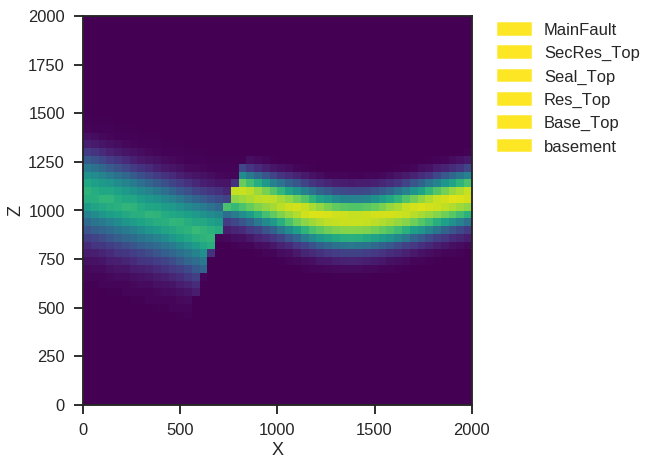

In [125]:
import matplotlib
norm = matplotlib.colors.Normalize(lith_prob[2].min(), lith_prob[2].max())
gp.plotting.plot_section(geo_data, lith_prob[2], cell_number=25, cmap='viridis',
                                     norm=norm)

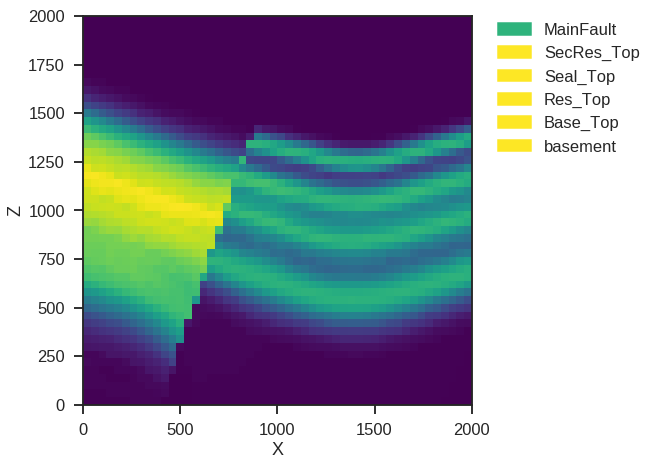

In [126]:
norm = matplotlib.colors.Normalize(lb_ie.min(), lb_ie.max())
gp.plotting.plot_section(geo_data, lb_ie, cell_number=25, cmap='viridis',
                                     norm=norm)

# POST ANALYSIS

In [127]:
from gempy import posterior_analysis_elisa as pa

In [128]:
post = pa.Posterior(dbname, interpdata=interp_data, entropy=False, geodata=geo_data)

In [129]:
vol_trace = post.db.trap_analysis[:][:,0]
ssf_trace = post.db.trap_analysis[:][:,1]
trap_control_trace = post.db.trap_analysis[:][:,2]

Text(0, 0.5, 'Probability')

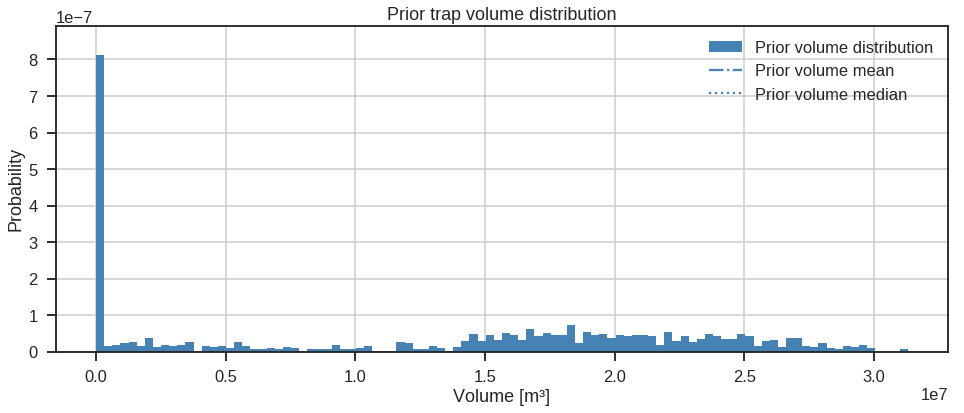

In [130]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(vol_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(vol_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(vol_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [62]:
#post = pa.Posterior(dbname, interpdata=interp_data, entropy=True, geodata=geo_data)

In [63]:
#post.i_need_this()
#post.get_points()

In [64]:
#ie = post.lb_ie

In [65]:
#post.calculate_ie_total(ie)

In [66]:
#post.plot_section_ie(plot_all_data=False)

In [67]:
#post.plot_section(1,fault=False)

In [68]:
# COUNT TRAP CONTROL OCCURRENCES
uniques, counts = np.unique(trap_control_trace, return_counts=True)
counts = np.round((counts/iterations)*100)

labels = ('UNCLEAR', 'SPILL POINT', 'LEAK UNDER', 'LEAK OVER', 'STRAT')
trap_base = dict(zip(labels, [0,0,0,0,0]))
trap_controls = dict(zip(labels, counts))

In [69]:
counts

array([36., 26., 30.,  8.])

In [81]:
post._change_input_data( 0)
interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
lith_block, fault_block = gp.compute_model(interp_data)

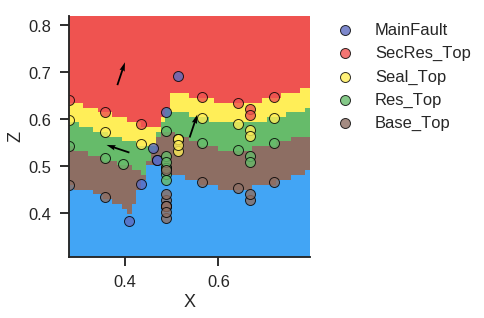

In [82]:
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, direction='y', plot_data=True)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          871.14776611]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 23232000.0 m³
TRAP VOXELS: 363


(23232000.0, 3.0, 1)

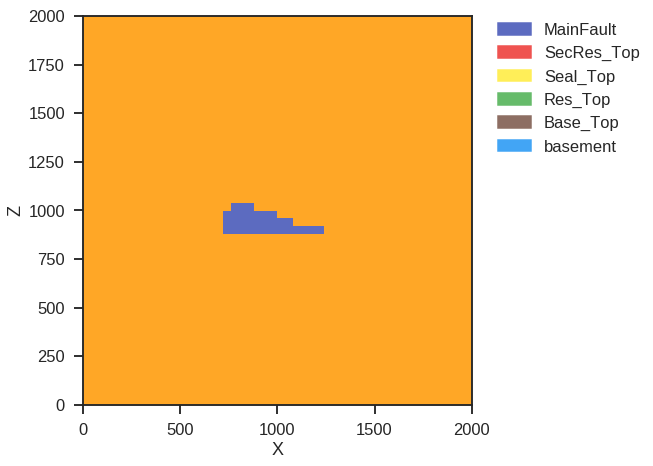

In [83]:
trap_analysis_post(lith_block, fault_block, print_figures=True)

In [84]:
#vol, SSF, tc = [],[],[]
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    #gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, plot_data=True)
#    v,s,c = trap_analysis_post(lith_sol, fault_sol, print_figures=True)
#    vol.append(v)
#    SSF.append(s)
#    tc.append(c)

AttributeError: 'Posterior' object has no attribute 'change_input_data'

In [67]:
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    gp.plotting.plot_section(interp_data.geo_data_res, lith_sol[0], 25, plot_data=True)

# POSTERIOR MODEL

In [131]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic(trace=True)
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(thicknesses[2], 150., 1./np.square(std1))

@pymc.stochastic(trace=True)
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(thicknesses[1], 350., 1./np.square(std2))

@pymc.stochastic(trace=True)
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(thicknesses[0], 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic(trace=True)
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

NameError: name 'sec_res_th' is not defined

In [65]:
iterations = 50

In [66]:
params = [input_data, thicknesses, gempy_model, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [67]:
dbname="trapmodel_lithTH"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"

In [68]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)

In [69]:
RUN.sample(iter=iterations)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [---              10%                  ] 5 of 50 complete in 0.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [------           16%                  ] 8 of 50 complete in 1.3 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------         22%                  ] 11 of 50 complete in 1.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------      30%                  ] 15 of 50 complete in 2.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------------   38%                  ] 19 of 50 complete in 2.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------46%                  ] 23 of 50 complete in 3.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------56%-                 ] 28 of 50 complete in 4.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------66%-----             ] 33 of 50 complete in 4.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------74%--------          ] 37 of 50 complete in 5.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------82%-----------       ] 41 of 50 complete in 5.7 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------90%--------------    ] 45 of 50 complete in 6.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------100%-----------------] 50 of 50 complete in 6.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------100%-----------------] 50 of 50 complete in 6.9 sec

In [ ]:
likelihoods = "thickness" # choose which likelihoods to use: "thickness", "SSF" or "both"

if likelihoods == "thickness":
    # Model inclucing only thickness likelihoods
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
elif likelihoods == "SSF":    
    # Model including only SSF likelihood
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, SSF_likelihood])
elif likelihoods == "both":
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, 
                          sec_res_th_likelihood, SSF_likelihood])
else:
    print("Did not understand which likelihood functions to use.")

In [ ]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [ ]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
#CUSTOM LOSS FUNCTION
estimates_s = np.arange(0,60000000, 10000)

# weight factors
o = 1.25
o_f = 2
u_f = 1.5

# risk factor range
risks_s = np.arange(0.5, 1.6, 0.25)


In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s,
                      true_s=max_volume_trace,
                      risk_range=risks_s,o=o,o_f=o_f,u_f=u_f)

In [ ]:
iterations=20

In [ ]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=0)

In [ ]:
#M_L.db.commit()
#M_L.db.close()

In [ ]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

structural_model_trace_L = M_L.trace('structural_model')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s, true_s=max_volume_trace_L,
                     risk_range=risks_s, o=o, o_f=o_f, u_f=u_f)

In [ ]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()